# Introduction to Natural Language Processing Catch-up 1

In [1]:
import string
import re
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## The Dataset

In [2]:
'''Load IMDB dataset'''
from datasets import load_dataset

dataset = load_dataset("imdb")

Reusing dataset imdb (C:\Users\GBO4\.cache\huggingface\datasets\imdb\plain_text\1.0.0\2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

1 . How many splits does the dataset has?

Le dataset a 3 split: test, train et unsupervised.

In [3]:
''' Converting dictionary to dataframe '''
train = pd.DataFrame.from_dict(dataset['train'])
test = pd.DataFrame.from_dict(dataset['test'])
unsupervised = pd.DataFrame.from_dict(dataset['unsupervised'])

train.shape, test.shape, unsupervised.shape

((25000, 2), (25000, 2), (50000, 2))

2 . How big are these splits?

Test et Train possèdes 25000 valeurs, et Unsupervised a 50000 valeurs.

In [4]:
test_labels = dataset["test"]["label"]
train_labels = dataset["train"]["label"]
print(train_labels.count(0), train_labels.count(1))
print(test_labels.count(0), test_labels.count(1))

12500 12500
12500 12500


3 . What is the proportion of each class on the supervised splits?

Les proportions de review négatives et positives sont de 50% dans les deux splits Train et Test.

## Naive Bayes classifier

1 . Create a pretreatment function

En plus de passer le texte en minuscule et de retirer les ponctuations j'ai décidé de retirer les balises HTML qui restait dans le dataset à l'aide d'une regex.

In [5]:
'''Function that removes punctuation, html tokens and make all the text to lower case'''
def preprocessing(text):
    text.translate(str.maketrans('', '', string.punctuation))
    html = re.compile('<.*?>')
    text = html.sub(r'', text)
    return text.lower()

In [6]:
''' Precporcessing on all of our splits '''

train["text"] = train["text"].apply(lambda x : preprocessing(x))
test["text"] = test["text"].apply(lambda x : preprocessing(x))
unsupervised["text"] = unsupervised["text"].apply(lambda x : preprocessing(x))

2 . Train a naive Bayes classifier on the training set.

Tokenization des review et transfomration du comptage de la fréquence de mots en valeurs TFIDF

In [7]:
''' Initialize a vector of frequency of top words for both split text review '''

''' number of top word to keep in the word count frequency '''
max_features = 50000

reviewTestVect = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, max_features=max_features)
reviewTestCount = reviewTestVect.fit_transform(test['text'])
 
reviewTrainVect = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, max_features=max_features)
reviewTrainCount = reviewTestVect.fit_transform(train['text'])

La variable max_feature permet de limiter le nombre de mots que l'on va prendre en compte dans notre modèle et permet aussi de s'assurer que les deux vecteurs auront les memes dimensions pour le training plus tard.

In [8]:
reviewTrainCount.shape, reviewTestCount.shape

((25000, 50000), (25000, 50000))

In [9]:
''' Converting word frequency to TFIDF values '''

transformerTrain = TfidfTransformer()
transformerTest = TfidfTransformer()
tfidfTrain = transformerTrain.fit_transform(reviewTrainCount)
tfidfTest = transformerTest.fit_transform(reviewTestCount)

tfidfTrain.shape, tfidfTest.shape

((25000, 50000), (25000, 50000))

On initialise nos X et Y en utilisant les bon splits pour Train et Test

In [10]:
x_train = tfidfTrain
x_test = tfidfTest

y_train = train.label
y_test = test.label

In [11]:
''' Set seed to make result reporductible '''

np.random.seed(42)

''' Initialize Multinomial Naive Bayes model and train it on Train dataset '''
clf = MultinomialNB().fit(x_train, y_train)

In [12]:
y_pred = clf.predict(x_test)
y_train_pred = clf.predict(x_train)

3 . Report the accuracy on both training and test set

In [13]:
''' Accuracy on Train split '''
print(sklearn.metrics.accuracy_score(y_train, y_train_pred))

0.90596


In [14]:
''' Accuracy on Test split '''
print(sklearn.metrics.accuracy_score(y_test, y_pred))

0.52072


4 . Why is accuracy a sufficient measure of evaluation here?

L'accuracy est ici une meusure suffisante d'évaluation car nous somme dans un problème de classification avec 2 classes et nos classes sont équilibré dans nos 2 splits.

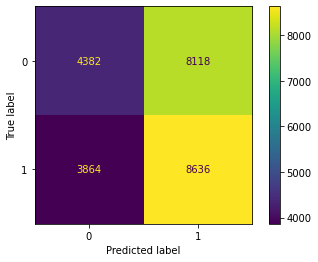

In [15]:
''' Display confusion matrix to have a better view of our classification on Test dataset'''

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

Le résultat de cet entraînement est moyennement satisfaisant mais on peut sans doute améliorer le résultat en réduisant notre nombre de "max_feature" pour se focaliser sur les mots importants de notre dataset. On voit que ce que notre modèle a le plus de mal à classer sont les review négatives.

6 . Take at least 2 wrongly classified example from the test set and try explaining why the model failed.

In [16]:
wrongly_classified = []
for review, category_pred, category_true in zip(test['text'], y_pred, y_test):
    if category_pred != category_true:
        wrongly_classified.append("pred : " + str(category_pred) + " true : " + str(category_true) + " review : " + review)

print(wrongly_classified[4])
print("-------------------")
print(wrongly_classified[5])

pred : 1 true : 0 review : i had high hopes for this one until they changed the name to 'the shepherd : border patrol, the lamest movie name ever, what was wrong with just 'the shepherd'. this is a by the numbers action flick that tips its hat at many classic van damme films. there is a nice bit of action in a bar which reminded me of hard target and universal soldier but directed with no intensity or flair which is a shame. there is one great line about 'being p*ss drunk and carrying a rabbit' and some ok action scenes let down by the cheapness of it all. a lot of the times the dialogue doesn't match the characters mouth and the stunt men fall down dead a split second before even being shot. the end fight is one of the better van damme fights except the director tries to go a bit too john woo and fails also introducing flashbacks which no one really cares about just gets in the way of the action which is the whole point of a van damme film.not good, not bad, just average generic actio

Dans les deux cas le modèle a prédit un avis positif alors que celui ci était négatif. Cela s'explique par le fait que dans les deux review l'utilisateur trouve quelques bons points aux films et le modèle se focalise sans doute sur les mots comme "nice", "better", "good" pour le classifier en tant que positif. De même on trouve finalement très peu de mots associé à un sentiment négatif dans ces deux review. Enfin la première des deux review ressemble quand même énormément à une review positive qui nous conseille d'aller voir se film même s'il n'est pas excelent donc très difficile à considérer comme une review "négaitve".

On change "max_feature" pour voir si on peut obtenir de meilleurs résultats.

0.8418
0.58232


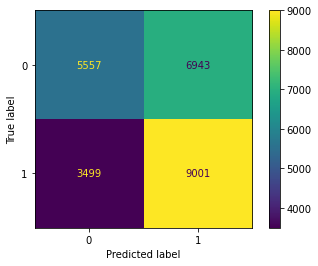

In [20]:
''' Changing max_feature to see if it gives better results '''

max_features = 1500

reviewTestVect = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, max_features=max_features)
reviewTestCount = reviewTestVect.fit_transform(test['text'])
 
reviewTrainVect = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize, max_features=max_features)
reviewTrainCount = reviewTestVect.fit_transform(train['text'])

''' Converting word frequency to TFIDF values '''

transformerTrain = TfidfTransformer()
transformerTest = TfidfTransformer()
tfidfTrain = transformerTrain.fit_transform(reviewTrainCount)
tfidfTest = transformerTest.fit_transform(reviewTestCount)

tfidfTrain.shape, tfidfTest.shape

x_train = tfidfTrain
x_test = tfidfTest

y_train = train.label
y_test = test.label

''' Set seed to make result reporductible '''

np.random.seed(42)

''' Initialize Multinomial Naive Bayes model and train it on Train dataset '''

clf = MultinomialNB().fit(x_train, y_train)

y_pred = clf.predict(x_test)
y_train_pred = clf.predict(x_train)

''' Accuracy on Train split '''
print(sklearn.metrics.accuracy_score(y_train, y_train_pred))

''' Accuracy on Test split '''
print(sklearn.metrics.accuracy_score(y_test, y_pred))

''' Display confusion matrix to have a better view of our classification on Test dataset'''

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_)
disp.plot()
plt.show()

On voit que l'on obtient de bien meilleurs (58% pour la classification Test) résultat en réduisant notre nombre de "max_features" on perd un petit peu de précision pour le True Positive mais on réduit grandement le nombre de False Positive.

## FastText

## Theoritical questions

1 . Definitions

Phonetics : 

La phonétique c'est l'étude des sons produits lorsque quelqu'un parle. Quand on parle de phonétiqeu on s'intéresse surtout à comment le son est produit , pourquoi il fait ce son et aussi le comparer avec d'autres sons. On s'interesse aussi à l'acoustique du son et à sa propagation dans l'air, comment il est perçu par quelqu'un d'autre et comment le cerveau l'interprête et aussi à l'aticulation donc à savoir quels mouvments la perosnne fait pour produire le son.

Phonology :

La phonologie est plus générale que la phonétique qui est une partie de la phonologie, car la cette denière se focalise sur la structure des phonèmes (différents sons qui une fois mis ensemble forme un mot) dans les mots. Ce qui compte dans la phonologie c'est comment ces phonèmes sont organisés et les structures similaires dans les mots et dans la langue de manières générale.

Morphology : 

C'est l'étude de la structure et de la classification des mots dans un language. C'est ici que l'on va retrouver les concept de racine, préfixe et suffixe et que l'ethymologie peut d'un mot rentre en compte. C'est le premier niveau où on va pouvoir relier les mots entre eux.

Syntax :

La syntahxe c'est l'ordre des mots dans une phrase, c'est ce qui donne une fonction à un mot dans la phrase comme verbe, sujet ou complément. Ici on commence à s'interesser aux relations fonctionnelles entres les mots.

Sementics :

La sémentique c'est le sens, les idées que véhicule un mot dans une phrase et les thèmes avec lesquels il est lié.

Pragmatics :

C'est la discipline qui s'intéresse au sens et à la fonction des mots du languages en prenant en compte le context dans lequel il est compris.

2 . What is the difference between stemming and lemmatization? 

Le stemming utilise une liste de préfix et de suffixe qui sera tronqué aux mots rnecontrés pour obtenir des "stem" ou souches. Pour cela on a besoin d'une liste avant de commencer notre algorithme pour pouvoir reconnaître et tronquer les suffixes et prefixes afin de ne plus qu'avoir les racines supposés des mots du tet qu'on veut analyser.

La lemmatization se base de son côté sur l'analyse morphologique des mots, pour cela l'algorithme se base sur un dictionnaire détaillé avec les relations entre les mots et remonte en partant du mot pour en retrouver la racine.

L'avantage du stemming c'est que c'est une méthode simple à implementer et qui nécessite certe une liste de suffixe et de préfixe mais qui arrive rapidement à des premiers resultats satisfaisant. Cependant on arrive très vite sur les limites du modèles quand beaucoup de mot ne sont pas simplement des racine avec des préfixes ou suffixe et que le mot change complètment de manière de s'ecrire comme par exemple en français "suis" est lié au verbe "être" mais n'a aucune lettre en commun pour retrouver une racine en tronquant le mot.

De son côté la lemmatization évite se problème avec l'aide d'un dictionnaire de mots très hierachisé et avec toutes les relatiosn morphologiques des mots. Cependant cela necessite beaucoup plus de connaissance linguistiques pour pouvoir être mis en place et beaucoup plus de temps. Mais cela nosu permet d'être ausiment sûr de retrouver les racines de mots de notre texte.

3 . On logistic regression

La descente de gradient stochastique est une méthode pour minimiser la fonciton de perte d'un modèle. Elle se fait à la fin de chaque exemple d'entrainement en faisant varier légerement le paramètre de notre fonction de perte afin de savoir dans quel direction elle diminue (principe de la descente de gradient).

Le rôle du taux d'aprentissage (learning rate) est de nous indiquer à quelle vitesse notre modèle s'adapte au problème qu'il essaye de résoudre. Cela nous permet de calibrer la durée de son entrainement et le nombre d'epochs afin d'eviter de se retrouver dans une soulution sous optimale ou que la progression du modèle soit bloquée dans son apprentissage.

Il est possible qu'on ne trouve pas de minimum si notre taux d'apprentissage est trop elevé et de même s'il est trop faible on peut se retrouver à être bloqué dans un minimum local.

4 . What problems does TF-iDF try to solve?

TF-iDF essaie de meusurer le poids d'un mot dans untexte donné en utilisant la fréquence à laquelle ce mot apparait ainsi qu'au nombre d'occurence de ce mot.

La partie TF (Terme Frequency) est le nombre d'occurence du terme dans le text. On va alors associer un poids à chaque mot qui est proportionnelle à son nombre d'occurence. 

La partie iDF (inverse Document Frequency) meusure à quel point un terme est présent dans un corpus de texte, on vise à trouver les terme qui sont discriminant dans le corpus avec cette partie et réduit l'importance des terme qui reviennent trop souvent.

5 . Summarize how the skip-gram method of Word2Vec works using a couple of paragraphs.

Le but de la méthode skip-gram est d'apprendre le context et la structure des mots dans un corpus en utilisant un réseau de neurone. Pour cela on utilise des exemples simple pour entrainer notre réseau de neurones le but est pour le moment de produire des sorties qui prédisent lesm ots autour du mot d'entré. On peut bien sur regler le nombre de mots autour que l'on veut prédire. Pour cela on part d'un couche d'entré qui est un vecteur de la taille de notre vocabulaire, une couche cachée, et une couche de sortie qui est une classification avec une fonction d'activation softmax. On fait une retropropagation à chaque passage d'un groupe d'entrainement visant un mot.

Le skip-gram est une méthode miroir à celle CBOW mais elle demande moins de données de test et représentes assez fidèlement les différents mots mêmes les plus rares du corpus. Cependant elle est plus longue à entrainer que CBOW.

In [18]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
